Ce tutoriel complet explore la construction d'un modèle de Deep Learning pour prédire le mouvement du prix de l'action NVDA sur une période de 5 jours (hausse ou baisse). Nous utiliserons Keras, une bibliothèque de Deep Learning facile à utiliser, pour construire notre modèle. En intégrant des indicateurs techniques de TA-Lib, en créant des caractéristiques de prix décalées (OHLCV) et en ajoutant des données d'actifs corrélés, nous cherchons à capturer des motifs complexes du marché et à améliorer la précision des prédictions.

Ce guide va au-delà de la simple construction du modèle ; nous évaluerons rigoureusement sa performance à l'aide de tests rétrospectifs sur des données historiques, en utilisant le ratio de Sharpe pour mesurer les rendements ajustés au risque. Que vous soyez un trader expérimenté ou débutant dans le domaine de la finance quantitative, ce guide vous fournira des informations précieuses et des techniques pratiques pour appliquer le Deep Learning aux marchés financiers.

Plan du tutoriel :

- Acquisition et Préparation des Données : Récupération des données historiques de l'action NVDA et nettoyage pour l'analyse.

- Ingénierie des Caractéristiques : Création de caractéristiques prédictives puissantes en utilisant des indicateurs techniques de TA-Lib, des données OHLCV décalées, et des prix d'actifs corrélés.
  
- Séparation des Données et Mise à l'Échelle : Division des données en ensembles d'entraînement et de test, et mise à l'échelle des caractéristiques pour éviter les biais.
  
- Construction du Modèle avec Keras : Conception d'un modèle de Deep Learning robuste en utilisant l'API Séquentielle de Keras pour la classification binaire.

- Entraînement et Évaluation du Modèle : Entraînement du modèle et visualisation de ses performances au fil des époques.

- Backtesting et Ratio de Sharpe : Mise en œuvre d'une stratégie de backtesting basée sur les prédictions du modèle et calcul du ratio de Sharpe pour évaluer les rendements ajustés au risque.

- Visualisation : Création de graphiques pour illustrer les indicateurs techniques, le progrès de l'entraînement du modèle et les signaux d'achat/vente du backtesting.
  
- Optimisation et Affinage du Modèle : Exploration des techniques de réglage des hyperparamètres et d'optimisation du modèle pour améliorer la précision des prédictions.

-- texte généré à l'aide de l'IA --

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas_ta as ta
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Data 

gs = yf.download("NVDA", start="2010-01-01", end="2024-08-01")
spy = yf.download("SPY", start="2010-01-01", end="2024-08-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
gs.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,0.46275,0.4655,0.45275,0.46225,0.423988,800204000
2010-01-05,0.46050,0.4740,0.46050,0.46900,0.430179,728648000
2010-01-06,0.46875,0.4730,0.46425,0.47200,0.432931,649168000
2010-01-07,0.46950,0.4715,0.45925,0.46275,0.424447,547792000
2010-01-08,0.45900,0.4670,0.45625,0.46375,0.425364,478168000


In [4]:
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,86.580727,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,86.809906,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,86.871056,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,87.237747,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,87.528061,126402800


In [8]:
# Traitement des valeurs manquantes 

gs.fillna(method='ffill', inplace=True) #Pour NVDA
spy.fillna(method='ffill', inplace=True) #Pour SPY

In [9]:
# Construction des indicateurs techniques via pandas_ta pour le titre NVDA

gs['RSI'] = ta.rsi(gs['Close'], length=14)
macd = ta.macd(gs['Close'], fast=12, slow=26, signal=9)
gs['MACD'], gs['MACD_signal'], gs['MACD_hist'] = macd['MACD_12_26_9'], macd['MACDs_12_26_9'], macd['MACDh_12_26_9']
bbands = ta.bbands(gs['Close'], length=20)
gs['upper_band'], gs['middle_band'], gs['lower_band'] = bbands['BBU_20_2.0'], bbands['BBM_20_2.0'], bbands['BBL_20_2.0']
gs['SMA_20'] = ta.sma(gs['Close'], length=20)
gs['EMA_12'] = ta.ema(gs['Close'], length=12)

In [10]:
for i in range(1, 6): 
    gs[f'Close_Lag_{i}'] = gs['Close'].shift(i) # Lagged OHLCV Features
    gs[f'Volume_Lag_{i}'] = gs['Volume'].shift(i) 

# Correlated Asset Features
gs['SPY_Close'] = spy['Close']

# Target Variable (5-Day Return)
gs['Target'] = np.where(gs['Close'].shift(-5) > gs['Close'], 1, 0)

In [11]:
# Data Cleaning (Post Feature Engineering)
gs.dropna(inplace=True)

In [12]:
# Train-Test Split
X = gs.drop('Target', axis=1)
y = gs['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Sequential Model

model = Sequential()

# Input Layer
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden Layers
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

#Performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5491 - loss: 0.6925 - val_accuracy: 0.5557 - val_loss: 0.6992
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.5737 - loss: 0.6833 - val_accuracy: 0.5461 - val_loss: 0.6843
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.5856 - loss: 0.6684 - val_accuracy: 0.5516 - val_loss: 0.6853
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.6015 - loss: 0.6644 - val_accuracy: 0.5585 - val_loss: 0.6834
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.5834 - loss: 0.6682 - val_accuracy: 0.5488 - val_loss: 0.6866
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5755 - loss: 0.6682 - val_accuracy: 0.5543 - val_loss: 0.6860
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.5991 - loss: 0.6593 - val_accuracy: 0.5543 - val_loss: 0.6833
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.6027 - loss: 0.6482 - val_accuracy: 0.57

In [15]:
# Prepare Trading Signals
y_pred = model.predict(X_test)
trading_signals = np.where(y_pred > 0.5, 1, 0)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [16]:
# Calculate Strategy Returns
gs_test = gs.iloc[-len(y_test):].copy()
gs_test['Signal'] = trading_signals
gs_test['Strategy_Returns'] = np.where(gs_test['Signal'] == 1, gs_test['Close'].pct_change(), 0)

# Sharpe Ratio
sharpe_ratio = np.sqrt(252) * (gs_test['Strategy_Returns'].mean() / gs_test['Strategy_Returns'].std())
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.5291


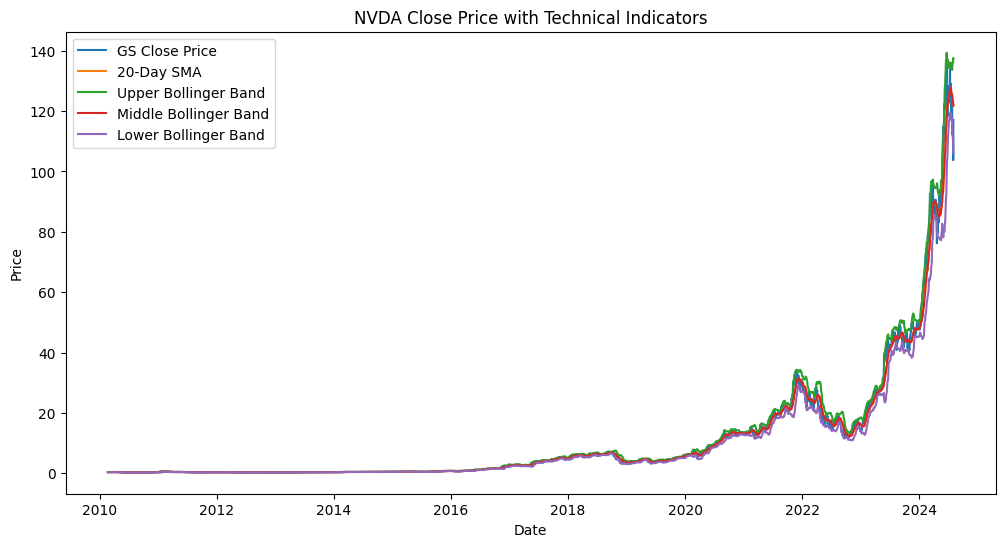

In [18]:
# Technical Indicators Visualization
plt.figure(figsize=(12, 6))
plt.plot(gs['Close'], label='GS Close Price')
plt.plot(gs['SMA_20'], label='20-Day SMA')
plt.plot(gs['upper_band'], label='Upper Bollinger Band')
plt.plot(gs['middle_band'], label='Middle Bollinger Band')
plt.plot(gs['lower_band'], label='Lower Bollinger Band')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NVDA Close Price with Technical Indicators')
plt.legend()
plt.show()

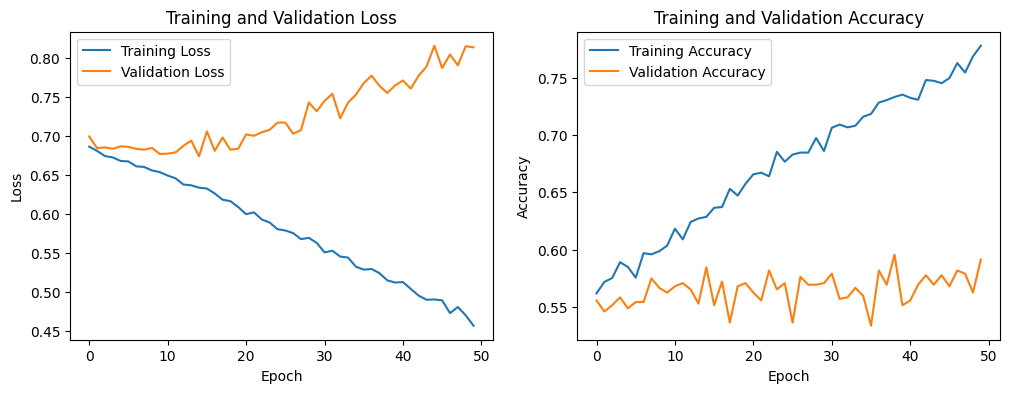

In [21]:
# Model Training Metrics Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

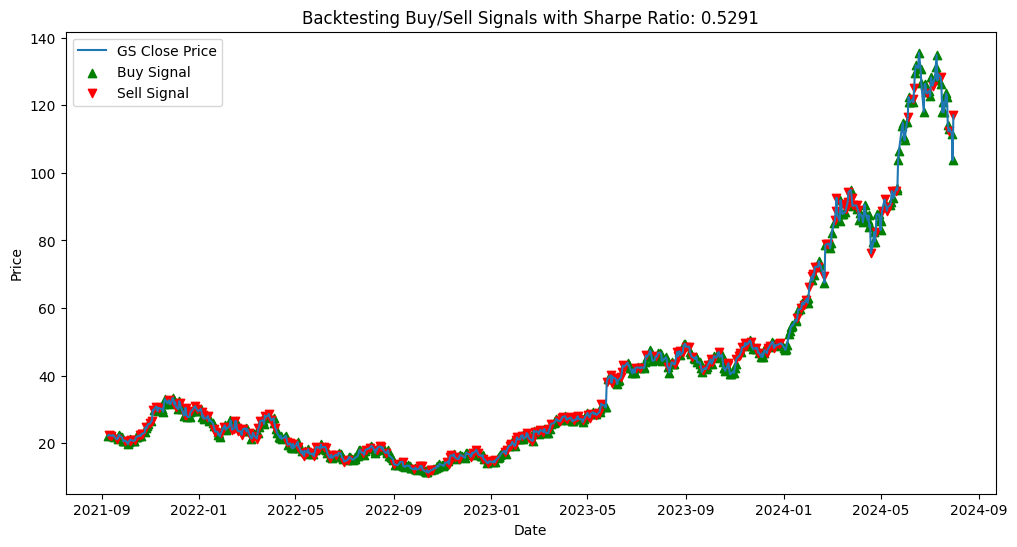

In [22]:
# Backtesting Buy/Sell Signals Visualization
plt.figure(figsize=(12, 6))
plt.plot(gs_test['Close'], label='GS Close Price')
plt.scatter(gs_test[gs_test['Signal'] == 1].index, gs_test[gs_test['Signal'] == 1]['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(gs_test[gs_test['Signal'] == 0].index, gs_test[gs_test['Signal'] == 0]['Close'], marker='v', color='red', label='Sell Signal')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Backtesting Buy/Sell Signals with Sharpe Ratio: {sharpe_ratio:.4f}')
plt.legend()
plt.show()

In [30]:
# Backtesting Buy/Sell Signals Dataframe

gs_test = gs.iloc[-len(y_test):].copy()
gs_test['Signal'] = trading_signals
gs_test['Strategy_Returns'] = np.where(gs_test['Signal'] == 1, gs_test['Close'].pct_change(), 0)

# Creating a table with date, close price, and signal (buy/sell)
signal_table = gs_test[['Close', 'Signal']].copy()
signal_table['Signal'] = signal_table['Signal'].map({1: 'Buy', 0: 'Sell'})

# Including the dates
signal_table['Date'] = gs_test.index
signal_table = signal_table[['Date', 'Close', 'Signal']] # Rearrange columns to have 'Date', 'Close', and 'Signal'
signal_table.head(1000)

,Date,Close,Signal
Date,,,
2021-09-09,2021-09-09,22.177000,Buy
2021-09-10,2021-09-10,22.478001,Sell
2021-09-13,2021-09-13,22.152000,Sell
2021-09-14,2021-09-14,22.242001,Buy
2021-09-15,2021-09-15,22.341000,Buy
...,...,...,...
2024-07-25,2024-07-25,112.279999,Sell
2024-07-26,2024-07-26,113.059998,Buy
2024-07-29,2024-07-29,111.589996,Buy
